In [37]:
import numpy as np
import pandas as pd
from sodapy import Socrata
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style()
plt.rcParams.update({
    "text.usetex": True,
#  "font.family": "serif",
# "font.serif": ["Palatino"],
})

import locale
locale.setlocale(locale.LC_ALL, '')

'LC_CTYPE=en_US.UTF-8;LC_NUMERIC=es_CO.UTF-8;LC_TIME=es_CO.UTF-8;LC_COLLATE=en_US.UTF-8;LC_MONETARY=es_CO.UTF-8;LC_MESSAGES=en_US.UTF-8;LC_PAPER=es_CO.UTF-8;LC_NAME=es_CO.UTF-8;LC_ADDRESS=es_CO.UTF-8;LC_TELEPHONE=es_CO.UTF-8;LC_MEASUREMENT=es_CO.UTF-8;LC_IDENTIFICATION=es_CO.UTF-8'

In [73]:
nombres_provincias = pd.read_csv("nombres_provincias_tildes.csv")
print(nombres_provincias.info())
nombres_provincias.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ciudad_municipio_nom  123 non-null    object
 1   Poblacion_2020        123 non-null    int64 
 2   bandera               118 non-null    object
 3   municipio_tildes      123 non-null    object
 4   provincia_tildes      123 non-null    object
 5   provincia_mayuscula   123 non-null    object
dtypes: int64(1), object(5)
memory usage: 5.9+ KB
None


,ciudad_municipio_nom,Poblacion_2020,bandera,municipio_tildes,provincia_tildes,provincia_mayuscula
0,ALMEIDA,1699,https://upload.wikimedia.org/wikipedia/commons...,Almeida,Oriente,ORIENTE
1,AQUITANIA,15060,https://upload.wikimedia.org/wikipedia/commons...,Aquitania,Sugamuxi,SUGAMUXI
2,ARCABUCO,5243,https://upload.wikimedia.org/wikipedia/commons...,Arcabuco,Ricaurte,RICAURTE
3,BELEN,7255,https://upload.wikimedia.org/wikipedia/commons...,Belén,Tundama,TUNDAMA
4,BERBEO,1934,https://upload.wikimedia.org/wikipedia/commons...,Berbeo,Lengupá,LENGUPA


In [39]:
# Get data for a specific Town
nombres_provincias.query("ciudad_municipio_nom=='TIBANA'")

,ciudad_municipio_nom,bandera,municipio_tildes,provincia_tildes,provincia_mayuscula
38,TIBANA,https://upload.wikimedia.org/wikipedia/commons...,Tibaná,Márquez,MARQUEZ


In [40]:
diccionario_provincias = nombres_provincias.set_index("provincia_mayuscula")["provincia_tildes"]
diccionario_provincias = diccionario_provincias.drop_duplicates()

In [41]:
# Get content of a specific provincia
nombres_provincias.query("provincia_mayuscula=='CENTRO'")

,ciudad_municipio_nom,bandera,municipio_tildes,provincia_tildes,provincia_mayuscula
0,CHIQUIZA,http://www.boyacacultural.com/images/stories/b...,Chíquiza,Centro,CENTRO
1,CHIVATA,https://upload.wikimedia.org/wikipedia/commons...,Chivatá,Centro,CENTRO
2,COMBITA,https://upload.wikimedia.org/wikipedia/commons...,Cómbita,Centro,CENTRO
3,CUCAITA,https://upload.wikimedia.org/wikipedia/commons...,Cucaita,Centro,CENTRO
4,MOTAVITA,https://upload.wikimedia.org/wikipedia/commons...,Motavita,Centro,CENTRO
5,OICATA,https://upload.wikimedia.org/wikipedia/commons...,Oicatá,Centro,CENTRO
6,SAMACA,https://upload.wikimedia.org/wikipedia/commons...,Samacá,Centro,CENTRO
7,SIACHOQUE,NaN,Siachoque,Centro,CENTRO
8,SORA,https://upload.wikimedia.org/wikipedia/commons...,Sora,Centro,CENTRO
9,SORACA,https://upload.wikimedia.org/wikipedia/commons...,Soracá,Centro,CENTRO


In [43]:
# Download Data

# Code Snippet taken from
# https://dev.socrata.com/foundry/www.datos.gov.co/gt2j-8ykr
#
# Useful documentation
# https://dev.socrata.com/docs/filtering.html

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("www.datos.gov.co", None)

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
q1 = "departamento=15"
results = client.get("gt2j-8ykr", where=q1, limit=1000000)
download_date = datetime.now() # Record date & time of data donwnload


# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

print("Data download date & time \n", download_date,"\n"*2)
results_df.info()

# Write date & Number of rows into n_reg.csv
n_rows,n_cols = results_df.shape
file_object = open('n_reg.csv', 'a')
n_entry = download_date.strftime('%d/%m/%y %H:%M') + "," + str(n_rows) + "\n"
print("\n"*2+"Writing to n_reg.csv \n--->", n_entry)
file_object.write(n_entry)
file_object.close()

Data download date & time 
 2021-06-16 07:08:02.907694 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77879 entries, 0 to 77878
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   fecha_reporte_web      77879 non-null  object
 1   id_de_caso             77879 non-null  object
 2   fecha_de_notificaci_n  77879 non-null  object
 3   departamento           77879 non-null  object
 4   departamento_nom       77879 non-null  object
 5   ciudad_municipio       77879 non-null  object
 6   ciudad_municipio_nom   77879 non-null  object
 7   edad                   77879 non-null  object
 8   unidad_medida          77879 non-null  object
 9   sexo                   77879 non-null  object
 10  fuente_tipo_contagio   77696 non-null  object
 11  ubicacion              77879 non-null  object
 12  estado                 77879 non-null  object
 13  recuperado             77879 non-null  object
 14  fecha_inicio

In [44]:
# Load Data
df = results_df.copy()
#del results_df

# Drop columns
drop_columns = ["departamento", 
                "departamento_nom", 
                "ciudad_municipio",
                "unidad_medida", 
                "per_etn_", 
                "nom_grupo_",
                "pais_viajo_1_cod",
                "pais_viajo_1_nom",
                "sexo",
                "fuente_tipo_contagio",
                "ubicacion",
                "estado",
                "tipo_recuperacion"
               ]
df = df.drop(columns=drop_columns)

# Transform dates to datetime objects using the propper format
dates = ["fecha_reporte_web", 
         "fecha_de_notificaci_n", 
         "fecha_inicio_sintomas", 
         "fecha_muerte", 
         "fecha_diagnostico", 
         "fecha_recuperado"
        ]
formated_dates = ["f_reporte_web", 
                  "f_notificacion", 
                  "f_ini_sintomas", 
                  "f_muerte", 
                  "f_diagnostico", 
                  "f_recuperacion"
                 ]
print("\n*** Formating Dates")
for i in range(len(dates)):
    print(dates[i], "\t\t--->", formated_dates[i])
    df[formated_dates[i]] = pd.to_datetime( df[dates[i]], format='%d/%m/%Y %H:%M:%S' )

df = df.drop(columns=dates)

print("\n*** Convert 'edad' from str to ints")
df["edad"] = df["edad"].astype(int)

# "Estado" column has NaN values for some cases with a valid pass-away date
# Correct those NaN with "Fallecido"
number_of_nans = np.sum(df["recuperado"]=="N/A")
print("\n*** Number of Nans in 'recuperado' column = ", number_of_nans)
if number_of_nans != 0:
    row_indexer = ~df["f_muerte"].isna() # rows with valid pass-away dates
    df.loc[ (row_indexer) , "recuperado" ] = "Fallecido" # Fix value for "Recuperado" column
    print("-->Correction of 'fallecido' value in 'recuperado' column for ", np.sum(row_indexer), "rows")
    
    number_of_nans = np.sum(df["recuperado"]=="N/A")
    print("After correction there are still ", number_of_nans, "N/A observations\n")
    print(df.loc[df["recuperado"]=="N/A",["id_de_caso","ciudad_municipio_nom","f_muerte","recuperado"]])
    
else:
    print("--> No Correction required")

# Add Provincias names
df = df.merge(nombres_provincias, on="ciudad_municipio_nom", how='left')
#df = df.drop(columns=["municipio_tildes","provincia_tildes"])
print("\n")
print(df.info())


print("\n*** Most recent reported dates\n", df.loc[:,formated_dates].max())
#df = df.drop(columns=["f_reporte_web","f_notificacion"])




*** Formating Dates
fecha_reporte_web 		---> f_reporte_web
fecha_de_notificaci_n 		---> f_notificacion
fecha_inicio_sintomas 		---> f_ini_sintomas
fecha_muerte 		---> f_muerte
fecha_diagnostico 		---> f_diagnostico
fecha_recuperado 		---> f_recuperacion

*** Convert 'edad' from str to ints

*** Number of Nans in 'recuperado' column =  299
-->Correction of 'fallecido' value in 'recuperado' column for  2114 rows
After correction there are still  1 N/A observations

      id_de_caso ciudad_municipio_nom f_muerte recuperado
38920    2012548             LA UVITA      NaT        N/A


<class 'pandas.core.frame.DataFrame'>
Int64Index: 77879 entries, 0 to 77878
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_de_caso            77879 non-null  object        
 1   ciudad_municipio_nom  77879 non-null  object        
 2   edad                  77879 non-null  int64         
 3   recuperad

## Resumen de casos por Provincia y por municipio

In [45]:
resumen_p = df.pivot_table(index="provincia_tildes", columns="recuperado", values="id_de_caso", aggfunc=np.count_nonzero).fillna(0)
resumen_p = resumen_p.sort_values("Activo", ascending=False)
#resumen["T"] = resumen.sum(axis=1) # Compute total observations to compare with number of "ID de caso"
resumen_p.astype(int).head(20)

# count "ID de caso" to compare with same calculation from the "Recuperado Column"
#df.groupby("Nombre municipio")["ID de caso"].agg(np.count_nonzero).sort_values(ascending=False)

recuperado,Activo,Fallecido,N/A,Recuperado
provincia_tildes,,,,
Centro,1239,448,0,23867
Tundama,531,486,0,16084
Sugamuxi,530,491,0,15253
Occidente,529,308,0,8148
Ricaurte,139,148,0,3127
Neira,68,42,0,1170
Norte,65,44,1,1380
Márquez,55,33,0,999
Lengupá,49,17,0,311


In [46]:
resumen_m = df.pivot_table(index="ciudad_municipio_nom", columns="recuperado", values="id_de_caso", aggfunc=np.count_nonzero).fillna(0)
resumen_m = resumen_m.sort_values("Activo", ascending=False)
#resumen["T"] = resumen.sum(axis=1) # Compute total observations to compare with number of "ID de caso"
print(resumen_m.astype(int).head(20))

# count "ID de caso" to compare with same calculation from the "Recuperado Column"
#df.groupby("Nombre municipio")["ID de caso"].agg(np.count_nonzero).sort_values(ascending=False)
top6 = resumen_m.sort_values("Activo", ascending=False).head(6).reset_index()["ciudad_municipio_nom"]
print("\n\nTOP 6\n",top6)

recuperado            Activo  Fallecido  N/A  Recuperado
ciudad_municipio_nom                                    
TUNJA                   1085        340    0       20270
SOGAMOSO                 440        427    0       12940
DUITAMA                  438        374    0       13065
CHIQUINQUIRA             379        149    0        4215
PAIPA                     72         73    0        2253
PUERTO BOYACA             72         96    0        2644
GARAGOA                   61         38    0         908
SAMACA                    54         31    0        1189
VILLA DE LEYVA            45         34    0         663
MIRAFLORES                44         11    0         223
SOATA                     41         13    0         637
MONIQUIRA                 38         68    0        1360
NOBSA                     34         13    0         950
MUZO                      25         11    0         300
TUTA                      23          6    0         233
SOCOTA                    15   

In [47]:
# Tag top-6 towns as "TOP 6" in provincia column
index_top6 = df["ciudad_municipio_nom"].isin(top6)
df.loc[index_top6,"provincia_mayuscula"] = "TOP 6"
df.loc[index_top6,"provincia_tildes"] = "Municipios con más Casos"

# List of Provincias
provincias = nombres_provincias["provincia_mayuscula"].value_counts()
provincias = list(provincias.index)
provincias.append("TOP 6")
print(provincias)

provincias_tildes = nombres_provincias["provincia_tildes"].value_counts()
provincias_tildes = list(provincias_tildes.index)
provincias_tildes.append("Municipios con más Casos")
print(provincias_tildes)


['OCCIDENTE', 'CENTRO', 'SUGAMUXI', 'RICAURTE', 'MARQUEZ', 'TUNDAMA', 'NORTE', 'ORIENTE', 'GUTIERREZ', 'VALDERRAMA', 'NEIRA', 'LENGUPA', 'LA LIBERTAD', 'TOP 6']
['Occidente', 'Centro', 'Sugamuxi', 'Ricaurte', 'Márquez', 'Norte', 'Tundama', 'Oriente', 'Gutiérrez', 'Valderrama', 'Lengupá', 'Neira', 'La Libertad', 'Municipios con más Casos']


Procesando Datos de Provincia --- OCCIDENTE


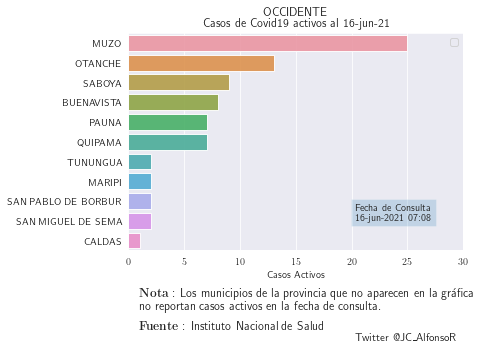

Procesando Datos de Provincia --- CENTRO


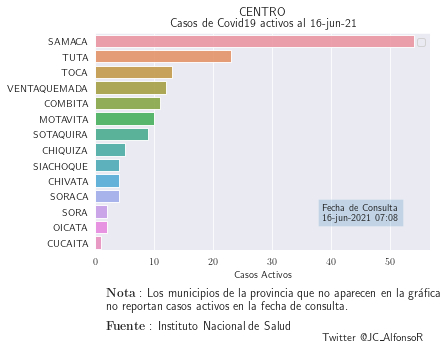

Procesando Datos de Provincia --- SUGAMUXI


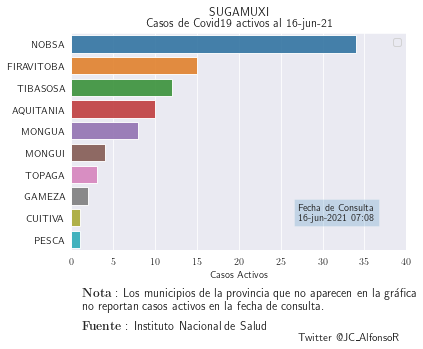

Procesando Datos de Provincia --- RICAURTE


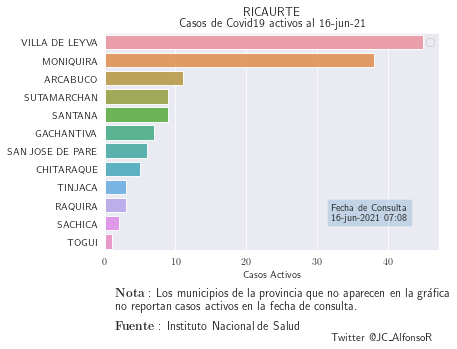

Procesando Datos de Provincia --- MARQUEZ


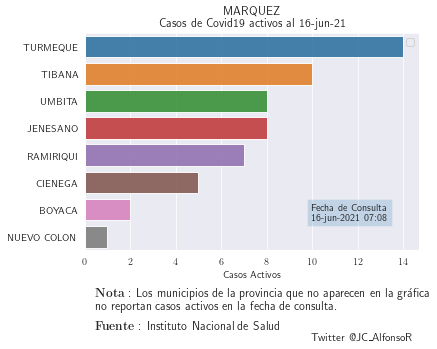

Procesando Datos de Provincia --- TUNDAMA


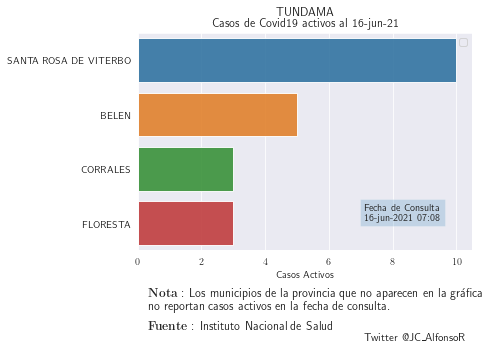

Procesando Datos de Provincia --- NORTE


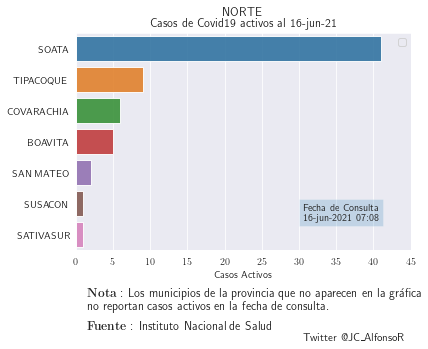

Procesando Datos de Provincia --- ORIENTE


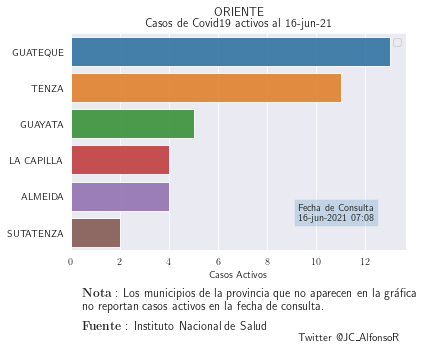

Procesando Datos de Provincia --- GUTIERREZ


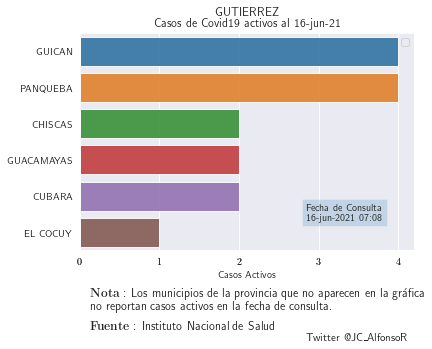

Procesando Datos de Provincia --- VALDERRAMA


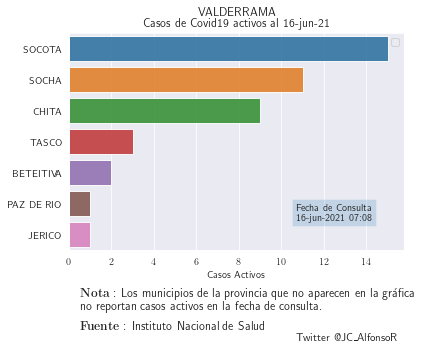

Procesando Datos de Provincia --- NEIRA


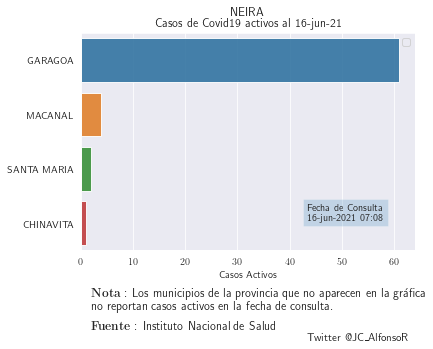

Procesando Datos de Provincia --- LENGUPA


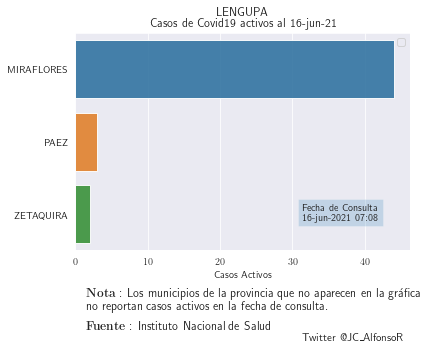

Procesando Datos de Provincia --- LA LIBERTAD


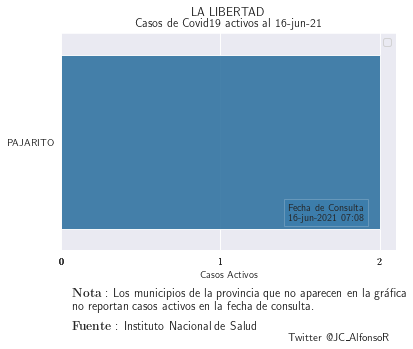

Procesando Datos de Provincia --- TOP 6


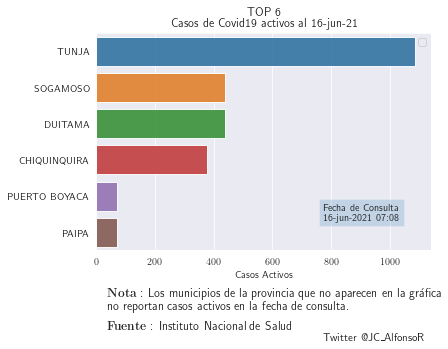

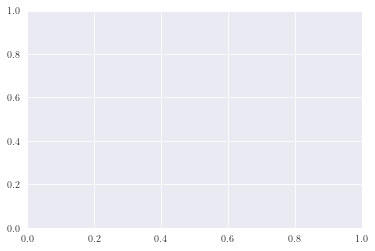

In [48]:
sns.set_style("darkgrid")

for provincia in provincias:
    print("Procesando Datos de Provincia ---", provincia)
    
    
    # Subset data
    #q1 = "recuperado=='Activo' or recuperado=='Fallecido'"
    q2 = "recuperado=='Activo'"
    df_subset = df.query(q2)
    df_subset = df_subset[df_subset.provincia_mayuscula==provincia]
    order_list = df_subset["ciudad_municipio_nom"].value_counts().index

    #Plot data
    g = sns.countplot(data=df_subset,
                 y="ciudad_municipio_nom", 
                       alpha=0.9,
                      order = order_list)
                    #hue="recuperado",
    #for p in ax.patches:
            #ax.annotate('{:f}'.format(p.get_height()), (p.get_x(), p.get_height()))
            #ax.annotate('{:d}'.format(p.get_width()), (p.get_width(),p.get_y()+0.5))

    # Miscellaneous
    g.set(xlabel= "Casos Activos",
          ylabel="",
          title= provincia + "\n Casos de Covid19 activos al " + download_date.strftime('%d-%b-%y'))
          #yticklabels=p_names_to_show)
    #plt.ylabel("")
    #plt.legend()
    #g.set_yticklabels(p_names_to_show)
    #plt.figtext(0.5, 0.01, "one text and next text", ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    # Make Sure x_ticks are ints
    old_ticks = g.get_xticks()
    floats_in_ticks = np.any(np.mod(old_ticks,2)!=0)
    if floats_in_ticks:
        new_ticks = old_ticks.astype(int)
        g.set_xticks(new_ticks)
    plt.legend("")
    disclaimer = r"$\bf{Fuente}$ : Instituto Nacional de Salud"

    disclaimer2 = r"$\bf{Nota}$ :" + " Los municipios de la provincia que no aparecen en la gráfica \nno reportan casos activos en la fecha de consulta."
    author = r"Twitter @JC\_AlfonsoR" 
    disclaimer4 = "Fecha de Consulta\n" + download_date.strftime('%d-%b-%Y %H:%M')

    figtext_start_y = -0.08
    fs = 12
    figtext_start_x = 0.15

    plt.figtext(figtext_start_x, 
                figtext_start_y-0.07, 
                disclaimer, 
                ha="left", fontsize=fs, wrap=True)

    plt.figtext(figtext_start_x, 
                figtext_start_y, 
                disclaimer2, 
                ha="left", fontsize=fs, wrap=True)

    plt.figtext(0.65, 
                figtext_start_y-1.5*0.07, 
                author, 
                ha="left", fontsize=fs-1, wrap=True)

    plt.figtext(0.65,
                0.23, 
                disclaimer4, 
                bbox={"alpha":0.2})
    
    #plt.tight_layout() # Make matplotlib save the whole figure content -> dont cut anything
    plt.savefig("log/"+provincia+'_'+download_date.strftime('%d_%m_%y_%H_%M')+'.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.cla()

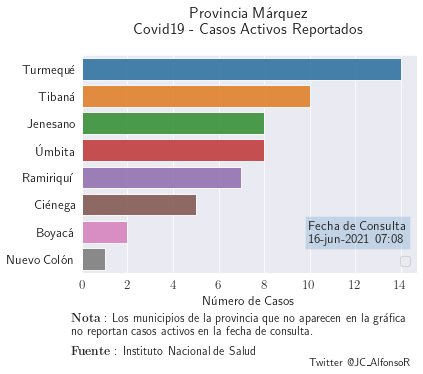

In [49]:
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 13
#  "font.family": "serif",
# "font.serif": ["Palatino"],
})

# Extract info from selected provincia
provincia = "MARQUEZ"

# Subset data
q1 = "recuperado=='Activo' or recuperado=='Fallecido'"
q2 = "recuperado=='Activo'"
df_subset = df.query(q2)
df_subset = df_subset[df_subset.provincia_mayuscula==provincia]
order_list = df_subset["municipio_tildes"].value_counts().index

#Plot data
g = sns.countplot(data=df_subset,
             y="municipio_tildes", 
                   alpha=0.9,
                  order = order_list)

#for p in g.patches:
        #g.annotate('{:d}'.format(p.get_width()), (p.get_width()+0.3,p.get_y()+0.5))

provincia_nombre = diccionario_provincias[provincia]
x_label =  "Número de Casos" 
title = "Provincia " + provincia_nombre + "\nCovid19 - Casos Activos Reportados\n"
# Miscellaneous
g.set(xlabel= x_label,
      ylabel="")
      #title=title)
plt.title(title)
plt.legend("")
#g.set_yticklabels(p_names_to_show)

# Make Sure x_ticks are ints
old_ticks = g.get_xticks()
floats_in_ticks = np.any(np.mod(old_ticks,2)!=0)
if floats_in_ticks:
    new_ticks = old_ticks.astype(int)
    g.set_xticks(new_ticks)
number =1

disclaimer = r"$\bf{Fuente}$ : Instituto Nacional de Salud"

disclaimer2 = r"$\bf{Nota}$ :" + " Los municipios de la provincia que no aparecen en la gráfica \nno reportan casos activos en la fecha de consulta."
author = r"Twitter @JC\_AlfonsoR" 
disclaimer4 = "Fecha de Consulta\n" + download_date.strftime('%d-%b-%Y %H:%M')

figtext_start_y = -0.09
fs = 12
figtext_start_x = 0.1

plt.figtext(figtext_start_x, 
            figtext_start_y-0.07, 
            disclaimer, 
            ha="left", fontsize=fs, wrap=True)

plt.figtext(figtext_start_x, 
            figtext_start_y, 
            disclaimer2, 
            ha="left", fontsize=fs, wrap=True)

plt.figtext(0.65, 
            figtext_start_y-1.5*0.07, 
            author, 
            ha="left", fontsize=fs-1, wrap=True)

plt.figtext(0.65,
            0.23, 
            disclaimer4, 
            bbox={"alpha":0.2})


#plt.autoscale()
#plt.tight_layout() # Make matplotlib save the whole figure content -> dont cut anything
plt.savefig('p.png',dpi=300,bbox_inches='tight')

# Time Series

In [50]:
# Generate dummi variables to easily create the time series
d_recuperado = pd.get_dummies(df["recuperado"], prefix='d')
d_df = pd.concat([df, d_recuperado], axis=1) 
d_df = d_df.drop(columns=["recuperado","d_Activo"])
d_df.head()

,id_de_caso,ciudad_municipio_nom,edad,f_reporte_web,f_notificacion,f_ini_sintomas,f_muerte,f_diagnostico,f_recuperacion,bandera,municipio_tildes,provincia_tildes,provincia_mayuscula,d_Fallecido,d_N/A,d_Recuperado
0,445,SANTANA,57,2020-03-25,2020-03-23,2020-03-13,NaT,2020-03-25,2020-04-06,https://upload.wikimedia.org/wikipedia/commons...,Santana,Ricaurte,RICAURTE,0,0,1
1,489,TUNJA,69,2020-03-26,2020-03-23,2020-03-22,NaT,2020-03-26,2020-04-06,https://upload.wikimedia.org/wikipedia/commons...,Tunja,Municipios con más Casos,TOP 6,0,0,1
2,690,OICATA,72,2020-03-29,2020-03-28,2020-03-25,NaT,2020-03-29,2020-04-11,https://upload.wikimedia.org/wikipedia/commons...,Oicatá,Centro,CENTRO,0,0,1
3,703,SANTANA,73,2020-03-30,2020-03-24,2020-03-18,NaT,2020-03-30,2020-04-13,https://upload.wikimedia.org/wikipedia/commons...,Santana,Ricaurte,RICAURTE,0,0,1
4,864,TUNJA,84,2020-03-31,2020-03-26,2020-03-22,2020-04-04,2020-03-31,NaT,https://upload.wikimedia.org/wikipedia/commons...,Tunja,Municipios con más Casos,TOP 6,1,0,0


In [51]:
# Create time series for active, recovered, passaway
# Each time series requires to be done independently

# Create acumulate time series using pivot tables
new_cases = d_df.pivot_table(index="f_ini_sintomas", 
                                  values="id_de_caso", 
                                  columns="ciudad_municipio_nom", 
                                  aggfunc=np.count_nonzero)
cum_new_cases = new_cases.sort_index(ascending=True).cumsum() 

new_rec = d_df.pivot_table(index="f_recuperacion",
                                values="d_Recuperado",
                                columns="ciudad_municipio_nom",
                                aggfunc=np.count_nonzero)
cum_rec = new_rec.sort_index(ascending=True).cumsum()

new_pa = d_df.pivot_table(index="f_muerte",
                              values="d_Fallecido",
                              columns="ciudad_municipio_nom",
                              aggfunc=np.count_nonzero)
cum_pa = new_pa.sort_index(ascending=True).cumsum()

In [52]:
# Resample all 3 time series in the same index so they can be summed
d_min = min([d_df.f_ini_sintomas.min(), d_df.f_recuperacion.min()])
d_max = max([d_df.f_ini_sintomas.max(), d_df.f_recuperacion.max()])
t_index = pd.date_range(start=d_min, end=d_max, freq='D')
print(d_min, d_max, sep="\n")

# Use pad() to fill values to the front and fillna(0) to fill NaN with 0
r_cum_new_cases = cum_new_cases.reindex(t_index).pad().fillna(0)
r_cum_rec = cum_rec.reindex(t_index).pad().fillna(0)
r_cum_pa = cum_pa.reindex(t_index).pad().fillna(0)

# Compute active cases: cumulative new cases - cummulative recovered - cummulative p.a.
active_cases = r_cum_new_cases - r_cum_rec - r_cum_pa

2020-03-13 00:00:00
2021-06-15 00:00:00


## Provincia Marquez

Text(0.5, 1.0, 'Casos Activos')

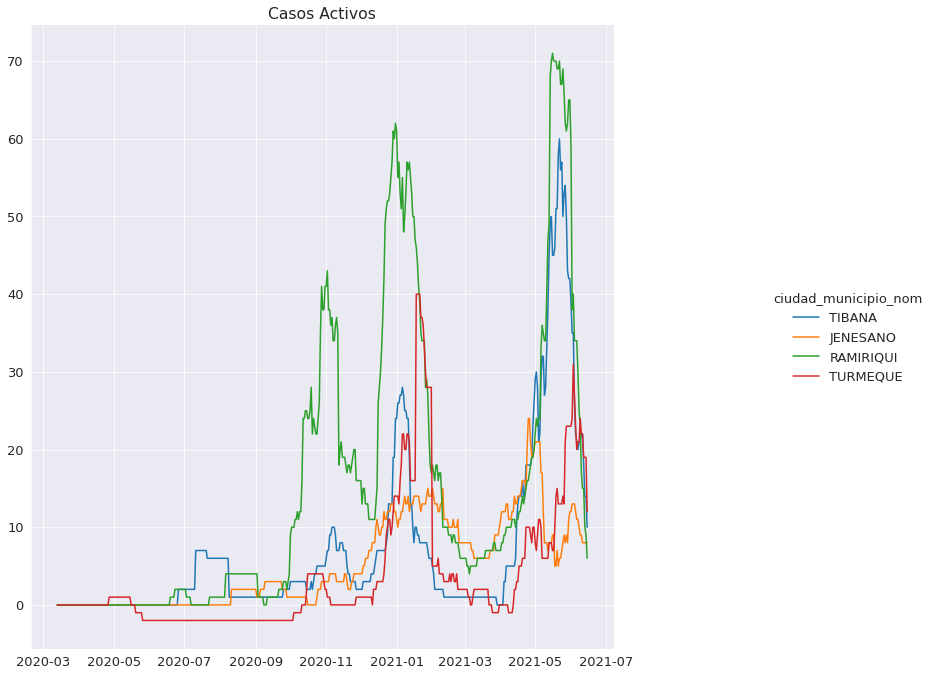

In [53]:
sns.set_style("darkgrid")
plt.rcParams.update({
    "text.usetex": False,
#  "font.family": "serif",
# "font.serif": ["Palatino"],
})


towns = ["TIBANA", "JENESANO", "RAMIRIQUI","TURMEQUE"]

g = sns.relplot(data=active_cases.loc[active_cases.index > "2020-01-01",towns],
           kind='line',
           dashes=False)

g.fig.set_size_inches(14,10)
#plt.grid()
plt.title("Casos Activos")
#plt.grid('both')
#old_ticks = g.ax.get_yticks()
#new_ticks = old_ticks.astype(int)
#g.ax.set_yticks(new_ticks)


# To Flourish

Export the time series of number of notified cases by town

In [54]:
df.info()
# f_reporte_web and f_notificacion are the only complete columns containing dates

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77879 entries, 0 to 77878
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_de_caso            77879 non-null  object        
 1   ciudad_municipio_nom  77879 non-null  object        
 2   edad                  77879 non-null  int64         
 3   recuperado            77879 non-null  object        
 4   f_reporte_web         77879 non-null  datetime64[ns]
 5   f_notificacion        77879 non-null  datetime64[ns]
 6   f_ini_sintomas        77305 non-null  datetime64[ns]
 7   f_muerte              2114 non-null   datetime64[ns]
 8   f_diagnostico         77871 non-null  datetime64[ns]
 9   f_recuperacion        72486 non-null  datetime64[ns]
 10  bandera               77510 non-null  object        
 11  municipio_tildes      77879 non-null  object        
 12  provincia_tildes      77879 non-null  object        
 13  provincia_mayusc

In [55]:
# Explore relationships between dates
df["diff"] = (df["f_reporte_web"] - df["f_notificacion"]) / np.timedelta64(1, 'D')
print("All data\n", df["diff"].describe(), "\n\n")
print("When f_reporte_web > f_notification\n", df.query("diff>0")["diff"].describe())

All data
 count    77879.000000
mean         9.378459
std          8.474851
min        -49.000000
25%          4.000000
50%          8.000000
75%         13.000000
max        271.000000
Name: diff, dtype: float64 


When f_reporte_web > f_notification
 count    77122.000000
mean         9.471526
std          8.461915
min          1.000000
25%          4.000000
50%          8.000000
75%         13.000000
max        271.000000
Name: diff, dtype: float64


In [56]:
# Print the anomalous data
df.query("diff<0").head(20)

,id_de_caso,ciudad_municipio_nom,edad,recuperado,f_reporte_web,f_notificacion,f_ini_sintomas,f_muerte,f_diagnostico,f_recuperacion,bandera,municipio_tildes,provincia_tildes,provincia_mayuscula,diff
304,69763,SOGAMOSO,36,Recuperado,2020-06-22,2020-06-23,2020-06-22,NaT,2020-06-28,2020-07-11,https://upload.wikimedia.org/wikipedia/commons...,Sogamoso,Municipios con más Casos,TOP 6,-1.0
2134,460347,TUNJA,19,Recuperado,2020-08-16,2020-08-18,2020-08-09,NaT,2020-08-21,2020-09-01,https://upload.wikimedia.org/wikipedia/commons...,Tunja,Municipios con más Casos,TOP 6,-2.0
3115,543537,TUNJA,38,Recuperado,2020-08-24,2020-08-26,2020-08-26,NaT,2020-08-28,2020-09-18,https://upload.wikimedia.org/wikipedia/commons...,Tunja,Municipios con más Casos,TOP 6,-2.0
3138,549354,TUNJA,4,Recuperado,2020-08-24,2020-08-26,2020-08-26,NaT,2020-08-28,2020-09-18,https://upload.wikimedia.org/wikipedia/commons...,Tunja,Municipios con más Casos,TOP 6,-2.0
8341,870215,CHIQUINQUIRA,14,Recuperado,2020-10-07,2020-10-09,2020-10-08,NaT,2020-10-09,2020-10-23,https://upload.wikimedia.org/wikipedia/commons...,Chiquinquirá,Municipios con más Casos,TOP 6,-2.0
9712,917665,TUNJA,60,Recuperado,2020-10-12,2020-11-30,2020-09-30,NaT,2020-10-11,2020-10-31,https://upload.wikimedia.org/wikipedia/commons...,Tunja,Municipios con más Casos,TOP 6,-49.0
10696,952992,TUNJA,21,Recuperado,2020-10-18,2020-10-24,2020-10-21,NaT,2020-11-04,2020-11-09,https://upload.wikimedia.org/wikipedia/commons...,Tunja,Municipios con más Casos,TOP 6,-6.0
12874,1031215,TUNJA,22,Recuperado,2020-10-27,2020-11-02,2020-11-02,NaT,2020-11-02,2020-11-28,https://upload.wikimedia.org/wikipedia/commons...,Tunja,Municipios con más Casos,TOP 6,-6.0
24103,1417456,PAIPA,83,Recuperado,2020-12-13,2020-12-21,2020-12-21,NaT,2020-12-21,2021-01-04,https://upload.wikimedia.org/wikipedia/commons...,Paipa,Municipios con más Casos,TOP 6,-8.0


The expected behavior is first notify, then report on the web

For the above few observations it was reversed. It Might be an error. 

Time discrepancies for 9 observations out of >70k is not significant in the graphics. So, I am going to process the Floursih data based on notitification date

In [57]:
# Data to expor to Flourish
# Create time series of new cases

# Create acumulate time series using pivot tables
notified_cases = df.pivot_table(index="f_notificacion", 
                                  values="id_de_caso", 
                                  columns="ciudad_municipio_nom", 
                                  aggfunc=np.count_nonzero)
cum_notified_cases = notified_cases.sort_index(ascending=True).cumsum()


# Resample time series
d_min = df["f_notificacion"].min()
d_max = df["f_notificacion"].max()
t_index = pd.date_range(start=d_min, end=d_max, freq='D')
print("Initial & Final Dates", d_min, d_max, sep="\n")

# Use pad() to fill NaN values to the front and fillna(0) to fill the remaining NaN with 0
r_cum_notified_cases = cum_notified_cases.reindex(t_index).pad().fillna(0)

Initial & Final Dates
2020-03-23 00:00:00
2021-06-13 00:00:00


In [58]:
# Check for NaN
print(r_cum_notified_cases.isna().any(), "\n")
print(r_cum_notified_cases.isna().any().any())

ciudad_municipio_nom
ALMEIDA           False
AQUITANIA         False
ARCABUCO          False
BELEN             False
BERBEO            False
                  ...  
UMBITA            False
VENTAQUEMADA      False
VILLA DE LEYVA    False
VIRACACHA         False
ZETAQUIRA         False
Length: 123, dtype: bool 

False


In [148]:
top_pc = to_flourish_p1000c.set_index("ciudad_municipio_nom").iloc[:,-6].sort_values(ascending=False)

In [153]:
# Transpose data because Flourish requires each town as a row
# Merge with nombres_provincias to load names, procincias and flag url
to_flourish = r_cum_notified_cases.T.merge(nombres_provincias, on="ciudad_municipio_nom", how='left')
to_flourish_p1000c = to_flourish.copy()
to_flourish_p1000c.iloc[:,1:-5] = to_flourish_p1000c.iloc[:,1:-5].div(to_flourish_p1000c.Poblacion_2020/1000, axis=0) # cases per 1000 hab

to_flourish = to_flourish.reset_index().drop(columns="index")
to_flourish_p1000c = to_flourish_p1000c.reset_index().drop(columns="index")

# Tag the top 6 towns
index_top6 = to_flourish["ciudad_municipio_nom"].isin(top6)
to_flourish.loc[index_top6,"provincia_mayuscula"] = "TOP 6"
to_flourish.loc[index_top6,"provincia_tildes"] = "Municipios con más Casos"

# Write CSV File
to_flourish.to_csv("timeSeries_Boyaca.csv")
to_flourish_p1000c.to_csv("timeSeries_p1000c_Boyaca.csv")

In [154]:
# Use terminal commands to delete 00:00:00 from the dates
!sed 's/00\:00\:00//g' timeSeries_Boyaca.csv -i
!sed 's/00\:00\:00//g' timeSeries_p1000c_Boyaca.csv -i
!head -1 timeSeries_Boyaca.csv

,ciudad_municipio_nom,2020-03-23 ,2020-03-24 ,2020-03-25 ,2020-03-26 ,2020-03-27 ,2020-03-28 ,2020-03-29 ,2020-03-30 ,2020-03-31 ,2020-04-01 ,2020-04-02 ,2020-04-03 ,2020-04-04 ,2020-04-05 ,2020-04-06 ,2020-04-07 ,2020-04-08 ,2020-04-09 ,2020-04-10 ,2020-04-11 ,2020-04-12 ,2020-04-13 ,2020-04-14 ,2020-04-15 ,2020-04-16 ,2020-04-17 ,2020-04-18 ,2020-04-19 ,2020-04-20 ,2020-04-21 ,2020-04-22 ,2020-04-23 ,2020-04-24 ,2020-04-25 ,2020-04-26 ,2020-04-27 ,2020-04-28 ,2020-04-29 ,2020-04-30 ,2020-05-01 ,2020-05-02 ,2020-05-03 ,2020-05-04 ,2020-05-05 ,2020-05-06 ,2020-05-07 ,2020-05-08 ,2020-05-09 ,2020-05-10 ,2020-05-11 ,2020-05-12 ,2020-05-13 ,2020-05-14 ,2020-05-15 ,2020-05-16 ,2020-05-17 ,2020-05-18 ,2020-05-19 ,2020-05-20 ,2020-05-21 ,2020-05-22 ,2020-05-23 ,2020-05-24 ,2020-05-25 ,2020-05-26 ,2020-05-27 ,2020-05-28 ,2020-05-29 ,2020-05-30 ,2020-05-31 ,2020-06-01 ,2020-06-02 ,2020-06-03 ,2020-06-04 ,2020-06-05 ,2020-06-06 ,2020-06-07 ,2020-06-08 ,2020-06-09 ,2020-06-10 ,2020-06-11 ,2020-0

In [61]:
# Plot data to verify
r_cum_notified_cases

ciudad_municipio_nom,ALMEIDA,AQUITANIA,ARCABUCO,BELEN,BERBEO,BETEITIVA,BOAVITA,BOYACA,BRICENO,BUENAVISTA,...,TUNJA,TUNUNGUA,TURMEQUE,TUTA,TUTAZA,UMBITA,VENTAQUEMADA,VILLA DE LEYVA,VIRACACHA,ZETAQUIRA
2020-03-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-09,57.0,194.0,143.0,219.0,27.0,15.0,252.0,79.0,24.0,95.0,...,21555.0,26.0,126.0,261.0,34.0,96.0,212.0,742.0,26.0,35.0
2021-06-10,57.0,194.0,143.0,219.0,27.0,15.0,252.0,79.0,24.0,99.0,...,21653.0,28.0,126.0,262.0,34.0,96.0,212.0,742.0,26.0,35.0
2021-06-11,57.0,194.0,143.0,219.0,27.0,15.0,252.0,79.0,24.0,99.0,...,21695.0,28.0,126.0,262.0,34.0,96.0,212.0,742.0,26.0,35.0
2021-06-12,57.0,194.0,143.0,219.0,27.0,15.0,252.0,79.0,24.0,99.0,...,21695.0,28.0,131.0,262.0,34.0,96.0,212.0,742.0,26.0,35.0


(array([18597., 18628., 18659., 18687., 18718., 18748., 18779.]),
 [Text(18322.0, 0, '2020-03'),
  Text(18383.0, 0, '2020-05'),
  Text(18444.0, 0, '2020-07'),
  Text(18506.0, 0, '2020-09'),
  Text(18567.0, 0, '2020-11'),
  Text(18628.0, 0, '2021-01'),
  Text(18687.0, 0, '2021-03')])

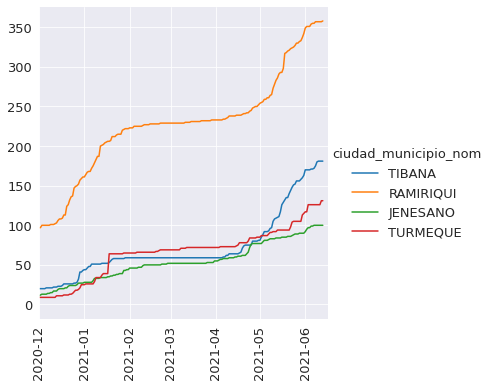

In [62]:
towns = ["TIBANA", "RAMIRIQUI", "JENESANO","TURMEQUE"]
g = sns.relplot(data=r_cum_notified_cases[towns],
           kind='line',
           dashes=False)

plt.xlim([np.datetime64("2020-12-01"),download_date])
plt.xticks(rotation=90)

In [63]:
print(r_cum_notified_cases[towns].iloc[-1])

ciudad_municipio_nom
TIBANA       181.0
RAMIRIQUI    358.0
JENESANO     100.0
TURMEQUE     131.0
Name: 2021-06-13 00:00:00, dtype: float64


In [64]:
n_entries_from_ts = r_cum_notified_cases.T.iloc[:,-1]
print(n_entries_from_ts)

ciudad_municipio_nom
ALMEIDA            57.0
AQUITANIA         194.0
ARCABUCO          143.0
BELEN             219.0
BERBEO             27.0
                  ...  
UMBITA             96.0
VENTAQUEMADA      212.0
VILLA DE LEYVA    742.0
VIRACACHA          26.0
ZETAQUIRA          35.0
Name: 2021-06-13 00:00:00, Length: 123, dtype: float64


In [65]:
n_entries = df.pivot_table(index="ciudad_municipio_nom", 
                                  values="id_de_caso",  
                                  aggfunc=np.count_nonzero)
print(n_entries)

                      id_de_caso
ciudad_municipio_nom            
ALMEIDA                       57
AQUITANIA                    194
ARCABUCO                     143
BELEN                        219
BERBEO                        27
...                          ...
UMBITA                        96
VENTAQUEMADA                 212
VILLA DE LEYVA               742
VIRACACHA                     26
ZETAQUIRA                     35

[123 rows x 1 columns]


In [66]:
# Print difference of reported cases computed with the two methods
# All should be 0
verify = np.array(n_entries_from_ts) - np.array(n_entries.id_de_caso)
print(verify, np.shape(verify))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] (123,)


# Recuperation period

In [67]:
recuperados = df.query("recuperado=='Recuperado'")
recuperados["Periodo_recuperacion"] = (recuperados["f_recuperacion"] - recuperados["f_ini_sintomas"])/np.timedelta64(1, 'D')

<ipython-input-67-2225461d1d66>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recuperados["Periodo_recuperacion"] = (recuperados["f_recuperacion"] - recuperados["f_ini_sintomas"])/np.timedelta64(1, 'D')


In [68]:
recuperados["Periodo_recuperacion"].describe()

count    71893.000000
mean        21.849234
std         24.348307
min          1.000000
25%         14.000000
50%         17.000000
75%         19.000000
max        349.000000
Name: Periodo_recuperacion, dtype: float64

(0.0, 50.0)

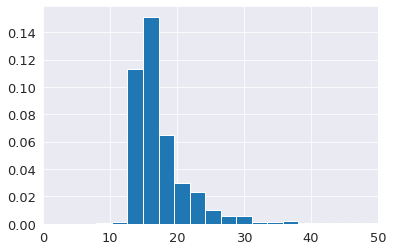

In [69]:
plt.hist(recuperados["Periodo_recuperacion"], bins=150, density=True)
plt.xlim([0,50])

(array([2.62798276e-04, 0.00000000e+00, 4.37997127e-04, 6.13195977e-04,
        1.31399138e-03, 2.10238621e-03, 2.62798276e-03, 5.86916150e-03,
        7.00795403e-03, 1.03367322e-02, 1.83958793e-02, 2.29510494e-02,
        2.40898420e-02, 2.05858650e-02, 2.51410351e-02, 2.45278391e-02,
        1.29647150e-02, 5.25596552e-03, 6.13195977e-04, 8.75994253e-05]),
 array([  1. ,   6.4,  11.8,  17.2,  22.6,  28. ,  33.4,  38.8,  44.2,
         49.6,  55. ,  60.4,  65.8,  71.2,  76.6,  82. ,  87.4,  92.8,
         98.2, 103.6, 109. ]),
 <BarContainer object of 20 artists>)

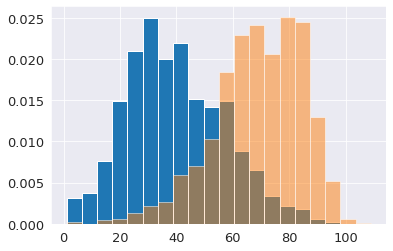

In [70]:
_, bins, _ = plt.hist(df.query("recuperado=='Recuperado'")["edad"], density=True, bins=20)
plt.hist(df.query("recuperado=='Fallecido'")["edad"], density=True, bins=bins, alpha=0.5)

# To Fix
* Define a Palette to show in red the town with most cases.
* Define if Palette is for showing scale or id
* Define if use positon for ID
* Think on processing counts by 1000 people.
* Plan a new visualization involving age